In [5]:
import pandas as pd 
import numpy as np 
import os 
import tensorflow as tf 
import tensorflow_addons as tfa
from tensorflow import keras 
import matplotlib.pyplot as plt
import cv2 
from glob import glob

import parameters
import dataset_generator 

# import data

In [2]:
base_models_path = 'C:/Users/user/Desktop/models/child_skin_classification_infection'
# dataset = 'C:/Users/user/Desktop/datasets/Child Skin Disease/Total_Dataset'
base_path = 'E:/Child Skin Disease(part)'
dataset_path = os.path.join(base_path, 'Total_Dataset')

In [3]:
test_images, test_labels = dataset_generator.create_test_list(dataset_path, part='head') 

Non-infection found : 12360, Infection found : 0


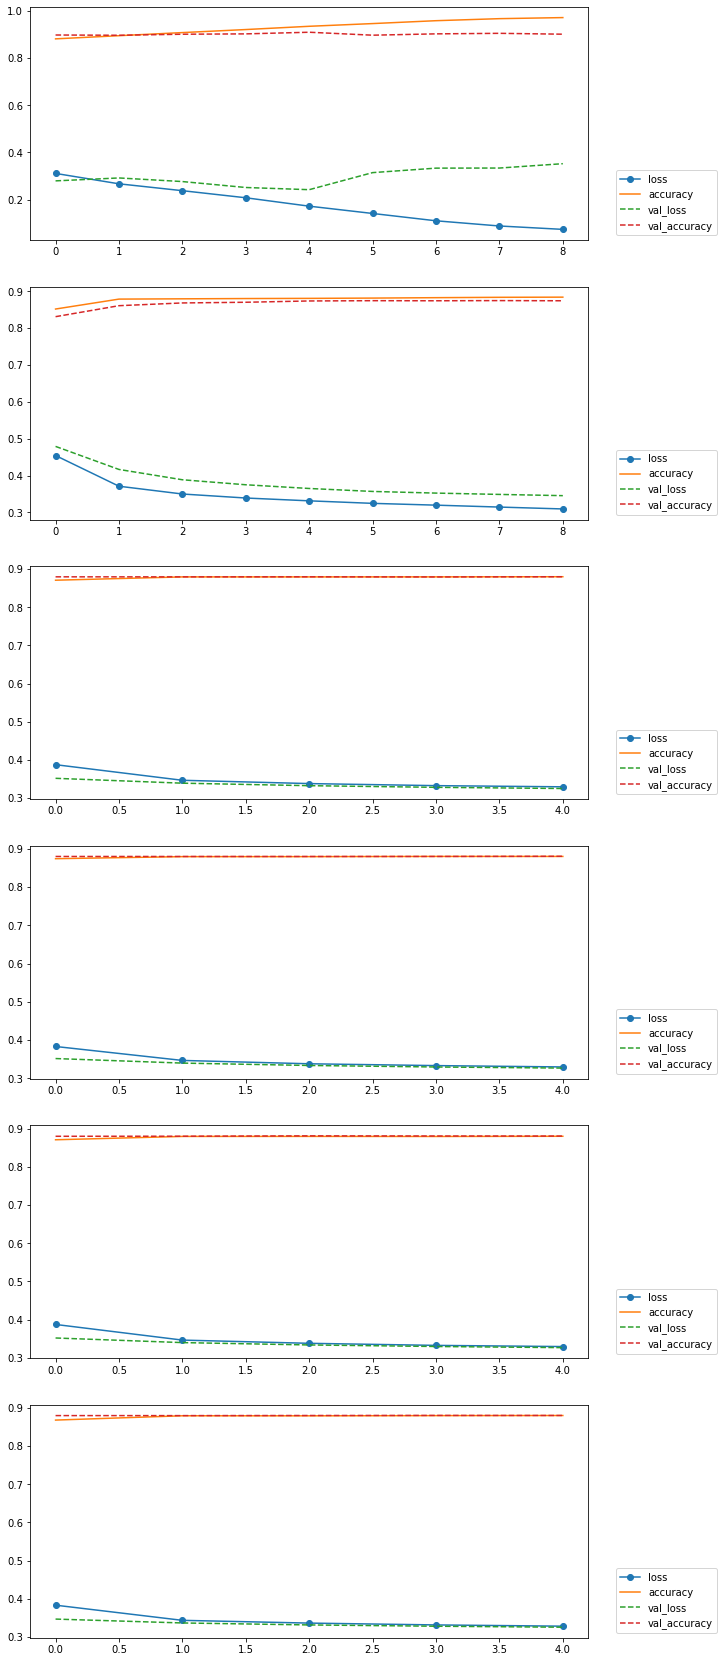

In [13]:
idx = 1
plt.figure(figsize=(10, 30))
for csv in glob(os.path.join(base_models_path, '20220712') + '/*.csv'): 
    df = pd.read_csv(csv) 
    
    plt.subplot(6, 1, idx) 
    
    plt.plot(df['loss'], marker='o', label='loss')
    plt.plot(df['accuracy'], label='accuracy')
    plt.plot(df['val_loss'], '--', label='val_loss')
    plt.plot(df['val_accuracy'], '--', label='val_accuracy')
    plt.legend(loc=(1.05, 0.02))
    
    idx += 1
    

plt.show()    
    

In [4]:
for h5 in glob(os.path.join(base_models_path, '20220712') + '/*.h5'):
    model = keras.models.load_model(h5) 
    
    loss, acc = model.evaluate(test_images, test_labels, batch_size=32)
    print(f'file : {h5}  loss : {loss}  accuracy : {acc}')

1302/1302 [==============================] - 95s 68ms/step - loss: 0.5760 - accuracy: 0.8790
file : C:/Users/user/Desktop/models/child_skin_classification_infection\20220712\20220712-032221_efficientb4_infection_kfold_5_1.h5  loss : 0.5759674310684204  accuracy : 0.879020631313324
1302/1302 [==============================] - 90s 68ms/step - loss: 0.3513 - accuracy: 0.8781
file : C:/Users/user/Desktop/models/child_skin_classification_infection\20220712\20220712-113943_efficientb4_infection_kfold_5_0.h5  loss : 0.35130807757377625  accuracy : 0.8781325221061707
1302/1302 [==============================] - 91s 69ms/step - loss: 0.3435 - accuracy: 0.8862
file : C:/Users/user/Desktop/models/child_skin_classification_infection\20220712\20220712-162427_efficientb4_infection_kfold_5_0.h5  loss : 0.343458354473114  accuracy : 0.8861978054046631
1302/1302 [==============================] - 93s 69ms/step - loss: 0.3473 - accuracy: 0.8856
file : C:/Users/user/Desktop/models/child_skin_classificati

In [6]:
# model = keras.models.load_model(os.path.join(base_models_path, '20220710-043340_efficientb4_infection_kfold_0.h5'), custom_objects={'focal_loss_fixed' : tfa.losses.SigmoidFocalCrossEntropy()})
model = keras.models.load_model(os.path.join(base_models_path, '20220902', 'min_check_point_efficient_20220901-161202.h5'))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

test_dataset = train_dataset = dataset_generator.create_dataset(test_images, test_labels) 

test_dataset = test_dataset.batch(parameters.num_batch, drop_remainder=True).prefetch(AUTOTUNE)

In [8]:
model.evaluate(test_dataset)

386/386 [==============================] - 1013s 3s/step - loss: 0.6617 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12352.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00


[0.6617462635040283, 0.0, 0.0, 12352.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [16]:
y_pred = [] 
y_true = [] 
threshold = 0.1

for img_batch, label_batch in test_dataset:
    y_true.append(label_batch) 
    
    preds = model.predict(img_batch) 
    
    # y_pred.append(np.argmax(preds, axis=-1))
    # y_pred.append(preds) 
    
    preds[preds >= threshold] = 1 
    preds[preds < threshold] = 0
    y_pred.append(preds) 
    
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [10]:
for c, p in zip(correct_labels, predicted_labels):
    if p >= 0.5:
        print(f'correct : {c}, predicted : {p}')

In [11]:
from sklearn.metrics import roc_curve
import sklearn

In [12]:
f1_score = sklearn.metrics.f1_score(correct_labels, predicted_labels)
precision = sklearn.metrics.precision_score(correct_labels, predicted_labels)
recall = sklearn.metrics.recall_score(correct_labels, predicted_labels)

f1_score, precision, recall

(0.0, 0.0, 0.0)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve
print("accuracy_score: {}".format( accuracy_score(correct_labels, predicted_labels)))
print("precision_score: {}".format( precision_score(correct_labels, predicted_labels)))
# print("AUC: Area Under Curve: {}".format(roc_auc_score(y_true, y_pred_proba[:, 1])))

accuracy_score: 1.0
precision_score: 0.0


In [14]:
cm = sklearn.metrics.confusion_matrix(correct_labels, predicted_labels)

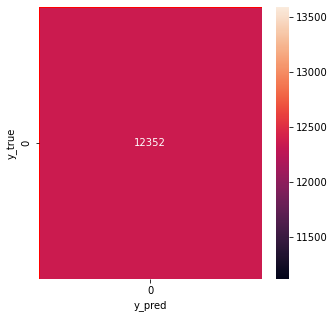

In [15]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='red', fmt='.0f', ax=ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')

plt.show()

In [17]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('FPR')    
    plt.ylabel('TPR')

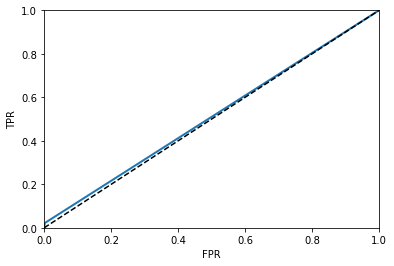

In [18]:
#roc curve 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, y_pred_copy)
# fpr, tpr, thresholds
plot_roc_curve(fpr, tpr)

In [19]:
from sklearn.metrics import auc 

auc(fpr, tpr)

0.5100880979369801